# Explore 'Disaster Tweets' dataset
*Coop team: Sarra Berich, Osman, Innaka Jessy*

with the growing use of social media, if we want to know people's reactions to a disaster we can analyze their tweets on the subject. The problem here is how will we know if the tweet is really about a disaster or not.

We would like in this project to predict if a tweet is a real disaster or not. To do this we will try to build different Machine learning models to find the best that can do the job. 

We will be using the dataset of 'Disaster Tweets' provided by the professor.

So before heading into the experimentation of various models, we lay out in this notebook the explotary data analysis (EDA).


## 1. Import

In [37]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import collections  as mc
%load_ext autoreload
%autoreload 2
import pandas as pd 
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
sns.set_style("white")

import string
import re

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


##2. Loading Data

Below is how the dataset looks like

In [38]:

df_train = pd.read_csv("https://raw.githubusercontent.com/sarrab/DMML2020_COOP/main/data/training_data.csv")
df_train.head()


,id,keyword,location,text,target
0,3738,destroyed,USA,Black Eye 9: A space battle occurred at Star O...,0
1,853,bioterror,NaN,#world FedEx no longer to transport bioterror ...,0
2,10540,windstorm,"Palm Beach County, FL",Reality Training: Train falls off elevated tra...,1
3,5988,hazardous,USA,#Taiwan Grace: expect that large rocks trees m...,1
4,6328,hostage,Australia,New ISIS Video: ISIS Threatens to Behead Croat...,1


In [39]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6471 entries, 0 to 6470
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        6471 non-null   int64 
 1   keyword   6416 non-null   object
 2   location  4330 non-null   object
 3   text      6471 non-null   object
 4   target    6471 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 252.9+ KB


In [40]:
df_train.shape

(6471, 5)

There are **6471** rows and **5** columns in the training data.
Since column text contains the tweets, our first assumption is that it might be the most important predictor.



```
# This is formatted as code
```

## 3. Columns : Types and Meaning

In [41]:
df_train.dtypes

id           int64
keyword     object
location    object
text        object
target       int64
dtype: object

This dataset contains tweets about whether or not a reported disaster is real. 
The features in the dataset are:

>	1.	`Id` : id of the tweet.
>	2.	`keyword`: a kind of a title for that paritucular disaster 
>	3.	`location`: the geographical location where that disaster happened.
>	4.	`text`: the disaster messages in form a tweet.
>	5.	`target`: value representing whether the reported tweet was true or not
    
Our task is to predict whether a tweet is real or not, i.e, we should use the target column as the labels.
We can see that the id column will not be useful for prediction.




##4.The feature 'Text'
Let's see an example of a real disater tweet.

###4.1 Quick look :Examples :Real Vs Fake

In [42]:
# a quick look on data
quick_look_real = df_train[df_train["target"] == 1 ]['text'].values[2]
quick_look_real

'New ISIS Video: ISIS Threatens to Behead Croatian Hostage Within 48 Hours - TLVFaces - TLVFaces#auspol http://t.co/a6PPEgeLOX'

And an example of not real one.

In [43]:
# a quick look on data
quick_look_fake = df_train[df_train["target"] == 0 ]['text'].values[2]
quick_look_fake

'Billionaires have a plan to free half a billion dollars trapped in Venezuela for two years @BlakeSchmidt reports.\r\n\r\nhttp://t.co/gbqTc7Sp9C'

We can see that tweets contains *urls* and *hashtags* and other things that can be removed. 

###4.2 Words Distribution

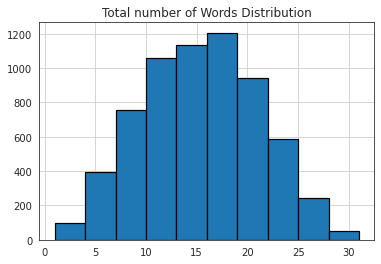

In [44]:
# let's split the words

df_train['totalwords'] = df_train['text'].str.split().str.len()


df_train['totalwords'].hist(edgecolor='black', linewidth=1.2)
plt.title('Total number of Words Distribution')
plt.show()

We can see that the length of tweets are mostly between 10 and 20 word.

### 4.3 Words Distribution Comparaison
Now let's compare the length of real disaster tweets and the not real ones in term of words!

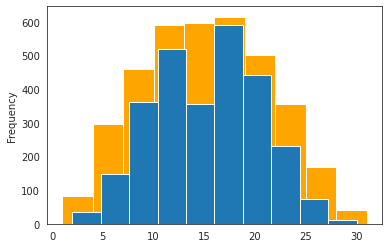

In [45]:
df_train['totalwords'][df_train['target'] == 0].plot.hist(color ='orange')
df_train['totalwords'][df_train['target'] == 1].plot.hist()

Compare now the number of characters of the real and fake disaster tweets.

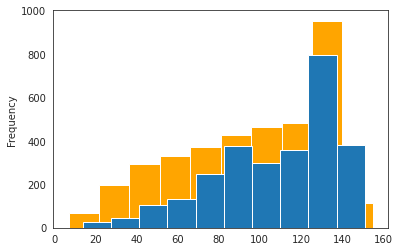

In [46]:
df_train['totalcharacter'] = df_train['text'].apply(lambda x: len(x))
df_train['totalcharacter'][df_train['target'] == 0].plot.hist(color = 'orange')
df_train['totalcharacter'][df_train['target'] == 1].plot.hist()

Let's compare the average of word length.

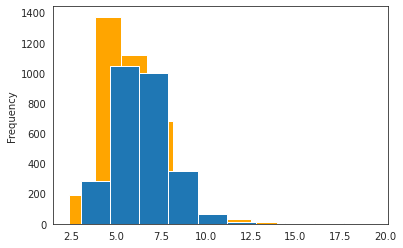

In [47]:
def avg_word_length(x):
    x = x.split()
    return np.mean([len(i) for i in x])

df_train['avg_word_length'] = df_train['text'].apply(avg_word_length)
df_train['avg_word_length'][df_train['target'] == 0].plot.hist(color = 'orange')
df_train['avg_word_length'][df_train['target'] == 1].plot.hist()

You find below an exploration of unique words.

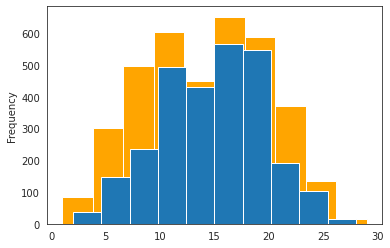

In [48]:
df_train['uniqueword'] = df_train['text'].apply(lambda x: len(set(x.split())))
df_train['uniqueword'][df_train['target'] == 0].plot.hist(color = 'orange')
df_train['uniqueword'][df_train['target'] == 1].plot.hist()

At the end of this exploration, we can see that real tweets and fakes tweets flow -more or less- similar distributions. However, real disaster tweets seem be longer than the fake ones. This may suggest to add the length of the text as a new featur.

##5. The feature 'Location'
let's take a look on the location feature!

Below is the location with the most fake disaster tweet 


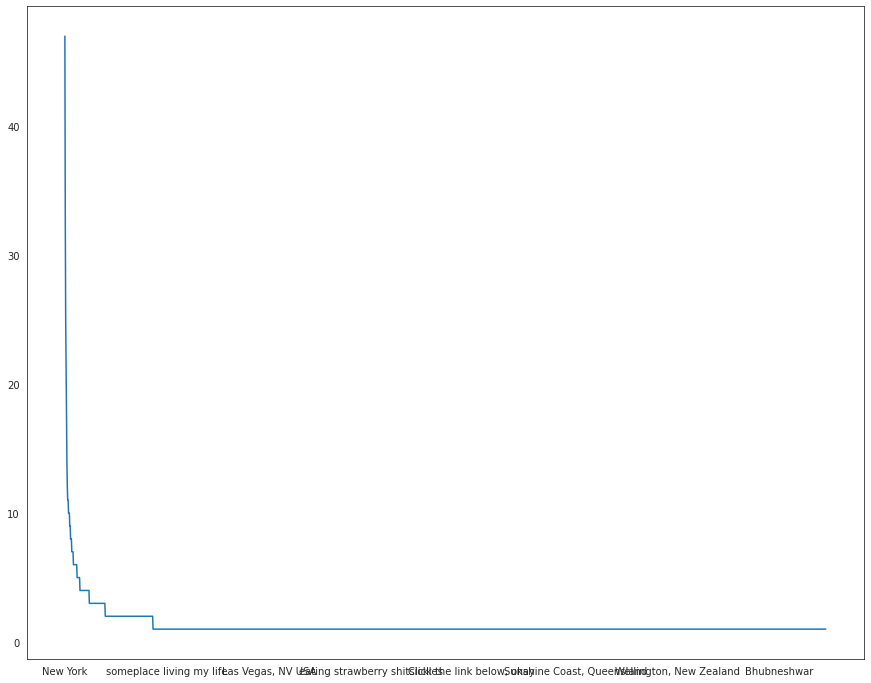

In [49]:
df_train['location'][df_train['target'] == 0].value_counts().plot(figsize=(15, 12))


Below is the  location with the most real disaster tweet .

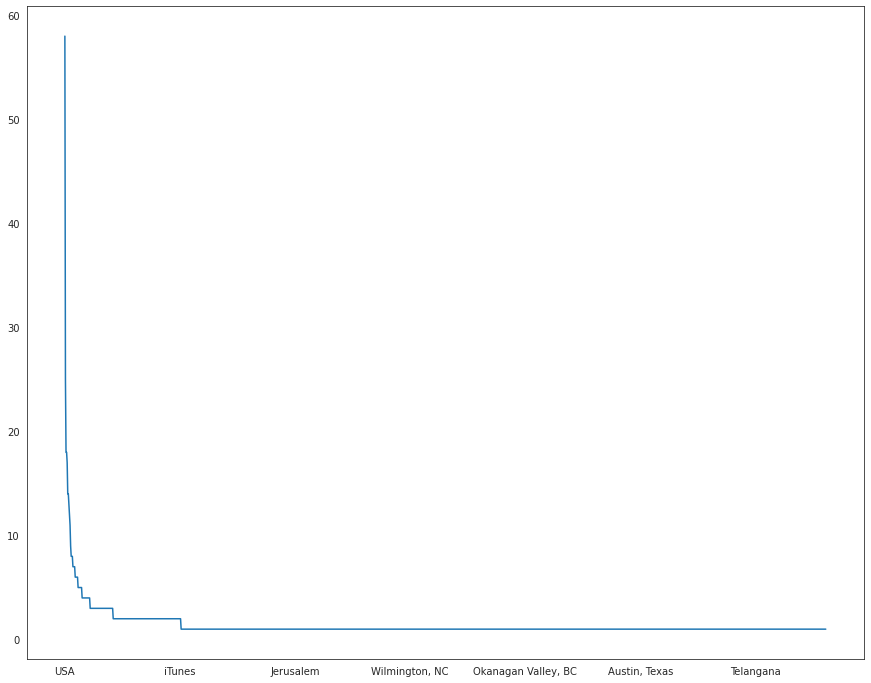

In [50]:
df_train['location'][df_train['target'] == 1].value_counts().plot(figsize=(15, 12))


In [51]:
df_train['location'].value_counts()

USA                             91
New York                        59
United States                   46
London                          39
Canada                          25
                                ..
Lawrence, KS via Emporia, KS     1
Aracaju - Sergipe                1
Warri                            1
Van Buren, MO                    1
back in japan ??????????         1
Name: location, Length: 2921, dtype: int64

Below is a represetation of the top locations.

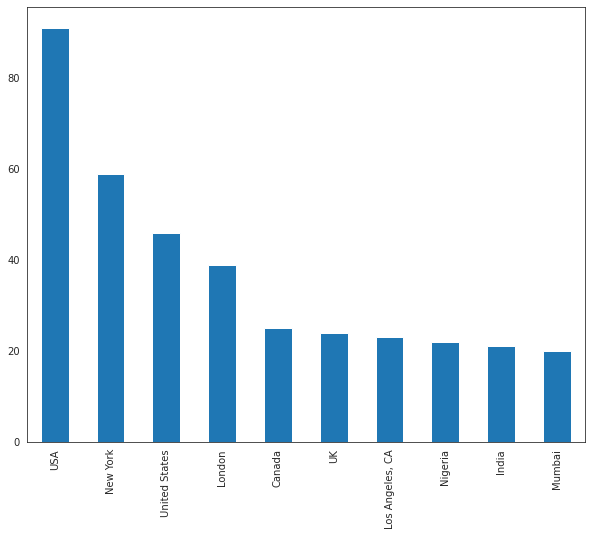

In [52]:
top_location = df_train['location'].value_counts()
top_location.head(10).plot(kind="bar", figsize=(10, 8))

We can see here that the most of not real disaster tweets come from New York. But the real ones come from USA . And we can see that there are many words that refer to the same location like (USA, United states, US), the comparason seem to be difficult.
We can olso observe that many 'locations' are not true locations loke iTunes or someplace...
So a suggestion for cleaning location feature would be normalizing locations names and clean non sens 'locations'.

## 6. Correlation

In [53]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
sns.set_style("white")

ohe = OneHotEncoder() #creating the object encoder 
# categorical_cols = ['keyword']
df_train["keyword"] = df_train.keyword.astype('category').cat.codes

df_train["location"] = df_train.location.astype('category').cat.codes
df_train

,id,keyword,location,text,target,totalwords,totalcharacter,avg_word_length,uniqueword
0,3738,74,2313,Black Eye 9: A space battle occurred at Star O...,0,19,106,4.631579,19
1,853,16,-1,#world FedEx no longer to transport bioterror ...,0,15,106,6.066667,15
2,10540,215,1746,Reality Training: Train falls off elevated tra...,1,12,105,7.833333,12
3,5988,121,2313,#Taiwan Grace: expect that large rocks trees m...,1,19,133,6.052632,19
4,6328,127,324,New ISIS Video: ISIS Threatens to Behead Croat...,1,17,125,6.411765,15
...,...,...,...,...,...,...,...,...,...
6466,4377,87,183,#Earthquake #Sismo M 1.9 - 15km E of Anchorage...,1,17,135,7.000000,17
6467,3408,68,-1,@EmiiliexIrwin Totally agree.She is 23 and kno...,0,25,140,4.640000,24
6468,9794,199,-1,Hollywood Movie About Trapped Miners Released ...,1,17,136,7.058824,16
6469,10344,211,375,Friendly reminder that the only country to eve...,1,20,133,5.700000,19


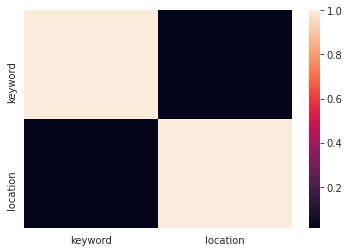

In [54]:
sns.heatmap(df_train[['keyword','location']].corr())

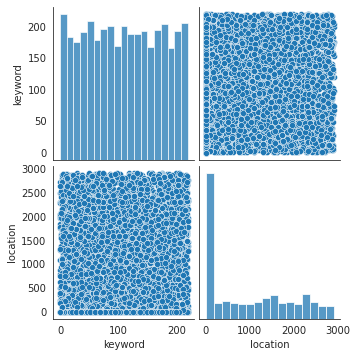

In [55]:
sns.pairplot(df_train[['keyword','location']]) #this function compares variables two by two

unfortunately, the heatmap didnt bring omething meaingful that we can use !

##7. The Base Rate 

In [56]:
base_rate = df_train.target.value_counts().max()/len(df_train)
print(f'\nThe base rate is {base_rate}')


The base rate is 0.5719363313243703


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


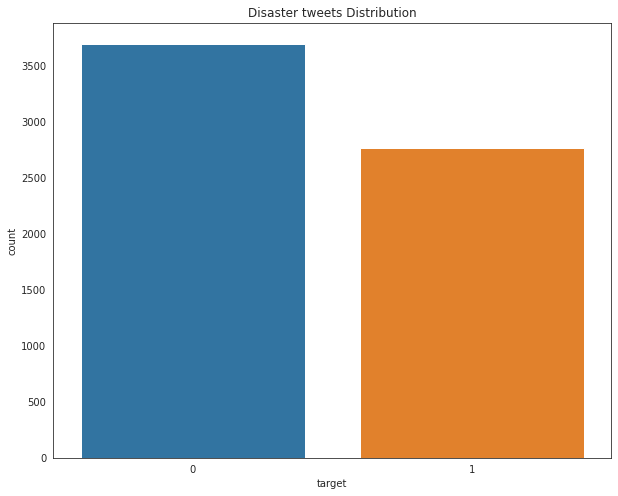

In [57]:

plt.subplots(1,1,figsize=(10,8))
sns.countplot('target',data=df_train) #this gives the frequency of each
plt.title("Disaster tweets Distribution")
plt.show()

As we can see above, the majority class is 'not true' (0) with 57%.
The dataset is +/- balanced. 

This is the end of the notebook dedicated to EDA. Therefore, we can experiment our models.
Here a model experimentation with all models (KNN, Decision Tree, Random Forest and Logistic Regression) trained  in cleand data.
And here is the lodel experimentation with only Logistic Regression with raw and  cleaned data. In this notebook, we also tried to deal with features selection.
After these tries, we impemented at the end a last version with most sophisticated cleaning and features engineering. 
